# 1. Equations aux dérivées partielles elliptiques

## 1.1 Position du problème

Nous nous proposons d’obtenir par la méthode des éléments finis une approximation de la solution
d’un problème dit de Laplace en deux dimensions muni de conditions aux limites mixtes (Dirichlet
et Neumann). Soit $\Omega$ = ]0,1[ $\times$ ]0,1[ $\subset \mathbb{R^2}$ et $\partial\Omega$ sa frontière partitionnée en deux sous-ensembles $\partial\Omega_n \cup \partial\Omega_d = \partial\Omega$. Etant donné $f \in L^2(\Omega)$, $u_{d} \in H^1(\Omega)$ et $g \in L^2(\partial \Omega_n)$, le problème de Laplace revient à déterminer $u$ solution de:
    $$
    \left\{
        \begin{array}{ll}
            -\Delta u(x,y) = f(x,y) &  sur ~ \Omega, \\
            u(x,y) = u_d(x,y) & sur  ~ \partial \Omega_d, \\
            \frac{\partial u(x,y)}{\partial n} = g(x,y) & sur ~ \partial \Omega_n
        \end{array}
    \right.
    $$

Nous nous proposons de résoudre le problème ci-dessus en le discrétisant par la méthode des éléments finis de Lagrange avec des élements finis de type $P_1$ (approximation polynômiale du premier degré sur un triangle ).

## 1.2 Partie théorique

$\underline{\textbf{Question :}}$

$\textbf{Montrer que la formulation variationnelle du problème s’écrit :}$
$$
\displaystyle \int_\Omega {\nabla v . \nabla w} \, \mathrm{d}x = \displaystyle \int_\Omega {fw} \, \mathrm{d}x + \displaystyle \int_{\partial\Omega_n} {g \gamma_0 (w)} \, \mathrm{d}\partial\Omega_n(x) - \displaystyle \int_\Omega {\nabla u_d . \nabla w} \, \mathrm{d}x
$$ 
avec $v,w \in H^1_0(\Omega)$, $v = u - u_d$.

$\underline{\textbf{Réponse :}}$

On commence par réécrire le problème au sens des distributions : 
$$
\left\{
    \begin{array}{ll}
        -\Delta u(x,y) = f(x,y) & sur \,  L^2(\Omega) \\
        \gamma_0 (u(x,y)) = u_d(x,y) & sur \,  H^1(\partial\Omega_d) \\
        \gamma_1 (u(x,y)) = g(x,y) & sur \,  L^2(\partial\Omega_n) 
    \end{array}
\right.
$$

Ensuite, si on intégre la première equation du système sur $\Omega$, on a : $$\displaystyle \int_\Omega {-\Delta u} \, \mathrm{d}x = \displaystyle \int_\Omega {f} \, \mathrm{d}x$$
En multipliant de plus par un $w \in L^2(\Omega)$ on obtient alors : $$\displaystyle \int_\Omega {-\Delta uw} \, \mathrm{d}x = \displaystyle \int_\Omega {fw} \, \mathrm{d}x$$

Soit $v \in H^1(\Omega)$ et $u \in H^2(\Omega)$, d'après la formule de Green, on a: $- \displaystyle \int_\Omega {\Delta u  v} \, \mathrm{d}x = \displaystyle \int_\Omega {\nabla u . \nabla v} \, \mathrm{d}x - \displaystyle \int_{\partial\Omega} {\gamma_1(u) \gamma_0 (v)} \, \mathrm{d}\partial\Omega(x) $.

Alors pour notre $u \in H^2(\Omega)$, et pour un $w \in H^1(\Omega)$ (car $H^1(\Omega) \subseteq L^2(\Omega) $), on aura $$\displaystyle \int_\Omega {\nabla u . \nabla w} \, \mathrm{d}x = \displaystyle \int_\Omega {fw} \, \mathrm{d}x + \displaystyle \int_{\partial\Omega} {\gamma_1(u) \gamma_0 (w)} \, \mathrm{d}\partial\Omega(x)$$
Ainsi $u \in H^1(\Omega)$.

On peut séparer l'integrale sur $\partial\Omega_n$ et $\partial\Omega_d$ car $\partial\Omega = \partial\Omega_n \bigcup \partial\Omega_d$, ce qui nous donne : $$\displaystyle \int_\Omega {\nabla u . \nabla w} \, \mathrm{d}x = \displaystyle \int_\Omega {fw} \, \mathrm{d}x + \displaystyle \int_{\partial\Omega_n} {\gamma_1(u) \gamma_0 (w)} \, \mathrm{d}\partial\Omega_n(x) $$

On a d'après la deuxième équation du système, $\forall(x,y) \in \partial\Omega_d$  $u(x,y) = u_d(x,y)$ donc $v = u - u_d \in H^1_0(\Omega)$.

Pour $w$ appartenant à $H^1_0(\Omega)$, $\gamma_0(w) = 0$ sur $\partial\Omega_d$, alors $\displaystyle \int_{\partial\Omega_d} {\gamma_1(u) \gamma_0 (w)} \, \mathrm{d}\partial\Omega_d(x) = 0$. 

De plus, on a $\forall(x,y) \in \partial\Omega_n$, $\gamma_1(u(x,y)) = \frac{\partial u(x,y)}{\partial n} = g(x,y)$.

Alors, on a bien: $$\displaystyle \int_\Omega {\nabla (v + u_d) . \nabla w} \, \mathrm{d}x = \displaystyle \int_\Omega {fw} \, \mathrm{d}x + \displaystyle \int_{\partial\Omega_n} {g \gamma_0 (w)} \, \mathrm{d}\partial\Omega_n(x)$$

Alors on a $$\displaystyle \int_\Omega {\nabla v . \nabla w} \, \mathrm{d}x = \displaystyle \int_\Omega {fw} \, \mathrm{d}x + \displaystyle \int_{\partial\Omega_n} {g \gamma_0 (w)} \, \mathrm{d}\partial\Omega_n(x) - \displaystyle \int_\Omega {\nabla u_d . \nabla w} \, \mathrm{d}x$$ avec $w \in H^1_0(\Omega)$ et $v \in H^1_0(\Omega)$ tel que $v = u - u_d$.

D'où le résultat.

$\underline{\textbf{Question :}}$

$\textbf{Montrer que le problème admet alors une unique solution.}$

On admet que $(H^1_0(\Omega), <.,.>_{1,\Omega})$ est un Hilbert avec 
$$
\forall (u,v) \in H^1_0(\Omega) \times H^1_0(\Omega), 
<u,v>_{1,\Omega} \, = \, \int_\Omega {\nabla u . \nabla v} \, dx 
$$

Le problème s'écrit $a(v,w) = l(w)$ avec 
$$
a : \left\{
    \begin{aligned}
        H^1_0(\Omega) \times H^1_0(\Omega) & \longrightarrow \mathbb{R}\\
        (v,w) & \longrightarrow \displaystyle \int_\Omega {\nabla v . \nabla w} \, dx \, = \, <v,w>_{1,\Omega}
    \end{aligned}
\right.
$$

et 
$$
l : \left\{
    \begin{aligned}
        H^1_0(\Omega) & \longrightarrow \mathbb{R}\\
        w & \longrightarrow \displaystyle \int_\Omega {fw} \, dx + \int_{\partial\Omega_n} {g\gamma_0(w)} \, dx - \int_\Omega {\nabla u_d . \nabla w} \, dx  
    \end{aligned}
\right.
$$

$\underline{\textbf{Réponse :}}$

- Montrons que a est une forme bilinéaire continue et coercive sur $H^1_0(\Omega) \times H^1_0(\Omega)$.

On sait que a est un produit scalaire sur $H^1_0(\Omega)$ donc a est une $\textbf{forme bilinéaire}$.

De plus, on a $\mid a(u,v)\mid = \mid <u,v>_{1,\Omega} \mid \leq \mid u\mid_{1,\Omega}\mid v\mid_{1,\Omega}$ d'après Cauchy-Schwarz donc a est $\textbf{continue}$. 

Enfin, on a $\mid a(u,u)\mid = \mid u\mid_{1,\Omega}^2$ donc on a $\mid a(u,u)\mid \geq \mid u\mid_{1,\Omega}^2$ d'où la $\textbf{coercivité}$ de a.


- Montrons que $l$ est une forme linéaire continue sur $H^1_0(\Omega)$.

On sait que $l$ est une somme d'intégrale donc $l$ est $\textbf{linéaire}$ par linéarité de l'intégrale et de la dérivée.

Ensuite, on a 
$$
\mid L(w) \mid = 
\mid <f,w>_{L^2(\Omega)} + <g,\gamma_0 (w)>_{L^2(\partial\Omega_n)} - <u_d , w>_{1,\Omega}\mid 
$$

d'où 
$$ 
\mid L(w)\mid \leq \mid <f,w>_{L^2(\Omega)}\mid + \mid<g,\gamma_0 (w)>_{L^2(\partial\Omega_n)}\mid + \mid<u_d , w>_{1,\Omega}\mid
$$ par inégalité triangulaire.

D'après Cauchy-Schwarz, on peut écrire 
$$
\mid L(w) \mid \leq \|f\|_{L^2(\Omega)}\|w\|_{L^2(\Omega)} + \|g\|_{L^2(\partial\Omega)}\|\gamma_0 (w)\|_{L^2(\partial\Omega)} + |u_d|_{1,\Omega}|w|_{1,\Omega}
$$

Par ailleurs, comme $\Omega$ est un ouvert fermé, on peut appliquer l'inégalité de Pointcarré qui énonce que pour un $C > 0$, $\|w\|_{L^2(\Omega)} \leq C |w|_{1,\Omega}$.
De plus, $\gamma_0$ étant continue, il existe un $M > 0$ tel que $\|\gamma_0 (w)\|_{L^2(\partial\Omega)} \leq M |w|_{1,\Omega}$.

Ainsi en injectant ces inéquations dans notre inéquation obtenue par Cauchy-Schwarz, on obtient :
$$
\mid L(w) \mid \leq (\|f\|_{L^2(\Omega)} C + \|g\|_{L^2(\partial\Omega)} M + |u_d|_{1,\Omega})|w|_{1,\Omega} 
$$

Donc $l$ est bien $\textbf{continue}$ sur $H_0^1(\Omega)$.

Comme $a$ est une forme bilinéaire continue coercive et $l$ est une forme linéaire continue, d'après le théorème de Lax-Milgram, il existe une unique solution $v \in H^1_0(\Omega)$ qui vérifie 
$$ 
\forall w \in H^1_0(\Omega), \, a(v,w) = l(w)
$$

Or on sait que $v = u - u_d$ donc si $v$ est unique, il en est de même pour $u$, solution du problème initial.

Ainsi le problème admet une unique solution.

$\underline{\textbf{Question :}}$

$$
\textbf{Montrer que la forme variationnelle discrète aboutit au système linéaire d’équations $Ax = b$ } \\
\textbf{avec $A \in \mathbb{R^{n \times n}}$, $x, b \in \mathbb{R^n}$ tels que :}
$$

$$ \begin{aligned}
& A_{ij} \, = \, \int_{\Omega} \nabla \eta_i^T \nabla \eta_j \, dx, \\
& b_i \, = \, \int_{\Omega} f \eta_i \, dx + \int_{\partial \Omega_n} g \eta_i \, dx - \sum_{k = 1}^n U_k \int_{\Omega} \nabla \eta_i^T \nabla \eta_k \, dx \\
\end{aligned} $$

où $n$ désigne le  nombre de degrés de liberté, $\eta_k$ les fonctions de base des éléments finis et la décomposition nodale de la condition limite est $\sum_{k = 1}^n U_k \eta_k$, avec $U_k = 0$ si $(x_k, y_k) \notin \partial \Omega_d$ et $U_k = u_d(x_k, y_k)$ sinon. 
$\textbf{Justifier l’existence et l’unicité de la solution discrète de ce système.}$

$\underline{\textbf{Réponse :}}$

Comme $(\eta_k)$ sont les fonctions de base des éléments finis de $n$ degrés de liberté, on peut définir toute fonction $h \in H^1_0(\Omega)$ tel que $h = \sum_{i=1}^n h_i \eta_i$.

Ainsi, on pose $v = \sum_{i=1}^n v_i \eta_i$ et $w = \sum_{i=1}^n w_i \eta_i$.

D'après la forme variationnelle discrète du problème, on cherche $u_k$ tel que $\forall w, \, a(v, w) \, = \, l(w)$ soit 
$$ 
a(\sum_{i=1}^n v_i \eta_i, \sum_{i=1}^n w_i \eta_i) \, = \, l(\sum_{i=1}^n w_i \eta_i) 
$$. 
Grâce à la bilinéarité de $a$ et la linéarité de $l$, on obtient :
$$
\sum_{i,j} v_i w_j a(\eta_i, \eta_j) = \sum_{i=1}^n w_i l(\eta_i)
$$

En passant le terme de droite à gauche, on trouve :
$$
\sum_{i=1}^n w_i \left(l(\eta_i) - \sum_{j=1}^n v_j a(\eta_i, \eta_j)\right) = 0
$$

Comme on prend $w \in H^1_0(\Omega)$ quelconque, on a 
$$
\forall i \in [1,n], \, l(\eta_i) - \sum_{j=1}^n v_j a(\eta_j,\eta_i) = 0
$$ soit 
$$
\sum_{j=1}^n v_j a(\eta_j,\eta_i) = l(\eta_i)
$$

Ce qui correspond bien au système $Ax = b$ avec $A \in \mathbb{R}^{n \times n}$, $x,b \in \mathbb{R}^n$ tels que 
$$
A_{ij} = a(\eta_j,\eta_i) = \int_\Omega {\nabla \eta_j . \nabla \eta_i} = \int_\Omega {\nabla \eta_i^T \nabla \eta_j},
$$
$$ x = (v_j)_{j \in [1, n]} $$

Par ailleurs, on sait que $\nabla u_d = \sum_{k=1}^n U_k \nabla \eta_k$ par définition de $U_k$, donc

$$ 
b_i = l(\eta_i) = \int_\Omega {f \eta_i} \, \mathrm{d}x + \int_{\partial\Omega_n} {g \gamma_0 (\eta_i)} \, \mathrm{d}x - \int_\Omega {(\sum_{k=1}^n U_k \nabla \eta_k) . \nabla \eta_i} \, \mathrm{d}x 
$$ 
$$ 
\Rightarrow b_i = \int_\Omega {f \eta_i} \, \mathrm{d}x + \int_{\partial\Omega_n} {g \eta_i} \, \mathrm{d}x - \sum_{k=1}^n U_k \int_\Omega {\nabla \eta_i^T \nabla \eta_k} \, \mathrm{d}x 
$$


## 1.3 Mise en oeuvre pratique

### 1.3.1 Maillages

In [41]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [42]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles;
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du care => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices
# des sommets d'un element triangle, dans le sens antihoraire.
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ;
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2));
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ;
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1
                coordinates[p,0] = x[i,0]
                coordinates[p,1] = x[j,0]
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1
                    p3 = p1 + n
                    p4 = p2 + n
                    e = e + 1
                    elements3[e,0] = p1
                    elements3[e,1] = p2
                    elements3[e,2] = p3
                    e = e + 1
                    elements3[e,0] = p4
                    elements3[e,1] = p3
                    elements3[e,2] = p2
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j

    return coordinates, elements3,dirichlet, neumann

In [43]:
def show(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True)
    plt.show()

### 1.3.2 Assemblage

$\underline{\textbf{Question :}}$

$\textbf{Etablir les formules donnant la matrice de raideur associée à un élément de type quadrangle.}$

$\underline{\textbf{Réponse :}}$

On sait que 
$$
\begin{aligned}
& \phi_1(\xi, \zeta) \, = \, (1 - \xi)(1 - \zeta), \\
& \phi_2(\xi, \zeta) \, = \, \xi(1 - \zeta), \\
& \phi_3(\xi, \zeta) \, = \, \xi \zeta, \\
& \phi_4(\xi, \zeta) \, = \, (1 - \xi) \zeta, \\
\end{aligned}
$$

Ainsi en dérivant, on obtient :
$$
\begin{aligned}
& \nabla \phi_1(\xi, \zeta) \, = \, \left(
    \begin{array}{ll}
        \zeta - 1\\
        \xi -1
    \end{array}
\right) \\
& \nabla \phi_2(\xi, \zeta) \, = \,  \left(
    \begin{array}{ll}
        1 - \zeta\\
        - \xi
    \end{array}
\right) \\
& \nabla \phi_3(\xi, \zeta) \, = \,  \left(
    \begin{array}{ll}
        \zeta\\
        \xi
    \end{array}
\right) \\
& \nabla \phi_4(\xi, \zeta) \, = \,  \left(
    \begin{array}{ll}
        - \zeta\\
        1 - \xi
    \end{array}
\right) \\
\end{aligned}
$$

Par application de la formule de changement de variables, on obtient l’expression suivante pour la matrice de raideur $M$ :
$$
M_{ij} =  \displaystyle \int_{[0,1]} \int_{[0,1]} {\nabla \phi_i^T (J_\phi^T J_\phi)^{-1} \nabla \phi_j |J_\phi|}\, \mathrm{d}\xi \, \mathrm{d}\zeta
$$ 

Notons $(J_\phi^T J_\phi)^{-1} = 
\left(
    \begin{array}{ll}
        a & b\\
        b & c
    \end{array}
\right)$ la matrice Jacobienne de $\phi$ symétrique. 

Pour trouver la matrice $M$, il faut calculer chaque élément $M_{ij}$ de la matrice.
Voici par exemple, le calcul de $M_{12}$ :

$$
\begin{aligned}
    & M_{12} = \int_{[0,1]} \int_{[0,1]} {\nabla \phi_1^T (J_\phi^T J_\phi)^{-1} \nabla \phi_2 |J_\phi|}\, \mathrm{d}\xi \, \mathrm{d}\zeta \\

    & M_{12} = |J_\phi| \int_{[0,1]} \int_{[0,1]} {\left(
        \begin{array}{ll}
            \zeta - 1 & \xi - 1
        \end{array}
    \right)  \left(
        \begin{array}{ll}
            a & b \\
            b & c
        \end{array}
    \right) \left(
        \begin{array}{ll}
            1 - \zeta \\
            - \xi
        \end{array}
    \right)}\, \mathrm{d}\xi \, \mathrm{d}\zeta \\

    & M_{12} = |J_\phi| \int_{[0,1]} \int_{[0,1]} {\left(
        \begin{array}{ll}
            (\zeta - 1)a + (\xi - 1)b & (\zeta - 1)b + (\xi - 1)c
        \end{array}
    \right) \left(
        \begin{array}{ll}
            1 - \zeta \\
            - \xi
        \end{array}
    \right)}\, \mathrm{d}\xi \, \mathrm{d}\zeta \\

     & M_{12} = |J_\phi| \int_{[0,1]} \int_{[0,1]} {-(\zeta - 1)^2 a + (\xi - 1)(\zeta - 1)b - \xi(\zeta - 1)b - \xi(\xi - 1)c \,} \, \mathrm{d}\xi \, \mathrm{d}\zeta \\

     & M_{12} = |J_\phi| \int_{[0,1]} {-\frac{a}{3} + \frac{b}{2}(\xi - 1) + \frac{b}{2}\xi - c \xi (\xi - 1)}\, \mathrm{d}\xi \\

     & M_{12} = |J_\phi| (-\frac{a}{3} - \frac{b}{4} + \frac{b}{4} + \frac{c}{6}) \\

     & M_{12} = \frac{|J_\phi|}{6} (-2a + c)

\end{aligned}
$$


Finalement, après avoir calculé chaque élément, on trouve que la matrice de raideur $M$ vaut :

$ M = \frac{|J_\phi|}{6}
\left(
    \begin{array}{ll}
        2a + 3b + 2c & -2a + c & -a -3b - c & a - 2c\\
        -2a + c & 2a - 3b + 2c & a - 2c & - a + 3b - c \\
        -a -3b - c & a - 2c & 2a + 3b + 2c & -2a + c \\
        a - 2c & - a + 3b - c & -2a + c & 2a - 3b + 2c
    \end{array}
\right)$

**Partie I : maillage triangulaire et conditions de Dirichlet**

In [44]:
def raideurElem(coordinates, T) :

    T = [coordinates[T[i]] for i in range(3)]

    alpha = (T[1][0] - T[0][0]) * (T[2][1] - T[0][1]) - (T[1][1] - T[0][1]) * (T[2][0] - T[0][0])
    gradEta = [[T[(j + 1) % 3][1] - T[(j + 2) % 3][1],
                T[(j + 2) % 3][0] - T[(j + 1) % 3][0]] for j in range(3)] /alpha
    gradEta = np.array(gradEta)
    aire = alpha/2
    M = aire * np.dot(gradEta, np.transpose(gradEta))

    return M

In [45]:
def raideur(n, coordinates, elements3) :
    A = np.zeros((n*n,n*n))
    for e in elements3 :
        M = raideurElem(coordinates, e)
        for i, elt_i in enumerate(e) :  #enumerate(e): pour trouver l'indice, puis la valeur
            for j, elt_j in enumerate(e) :
                A[elt_i, elt_j] += M[i][j]

    return A

In [46]:
def secondMembreElem(n, coordinates, E, A, ud, f, frontiere) :
    bElem = np.zeros(len(E))
    Ecoordinates = [coordinates[E[i]] for i in range(len(E))]

    if (len(E)) == 3 :
        alpha = (Ecoordinates[1][0] - Ecoordinates[0][0]) * (Ecoordinates[2][1] - Ecoordinates[0][1]) - (Ecoordinates[1][1] - Ecoordinates[0][1]) * (Ecoordinates[2][0] - Ecoordinates[0][0])
    elif (len(E)) == 4 :
        Jacobien = np.array([[Ecoordinates[1][0]-Ecoordinates[0][0], Ecoordinates[3][0]-Ecoordinates[0][0]],
                         [Ecoordinates[1][1]-Ecoordinates[0][1], Ecoordinates[3][1]-Ecoordinates[0][1]]])
        alpha = Jacobien[0][0] * Jacobien[1][1] - Jacobien[0][1] * Jacobien[1][0]

    xg, yg = sum(Ecoordinates)/len(E)


    for i,e in enumerate(E) :
        if (len(E)) == 3 :
            terme1 = alpha*f(xg,yg)/6
        elif (len(E)) == 4 :
            terme1 = alpha*f(xg,yg)/4

        terme2 = sum(ud * frontiere * A[e])

        bElem[i] = terme1 - terme2

    return bElem

In [47]:
def bNeuman(n, indNeumann, coordinates, g) :
    
    b = np.zeros(n*n)
    for e in indNeumann :
        
        l = np.linalg.norm(coordinates[e[0]] - coordinates[e[1]])
        bar = (coordinates[e[0]] + coordinates[e[1]]) / 2
    
        x = bar[0]
        y = bar[1]
        b[indNeumann[0]] += l * g(x,y) / 2
        b[indNeumann[1]] += l * g(x,y) / 2
    return b

In [48]:
def secondMembre(n, coordinates, A, ud, f, elements3) :
    frontiere = np.zeros(n*n)
    for i in range(n*n) :
        if i <= n or i%n == 0 or i%n == n-1 or i >= (n-1) * n:
            frontiere[i] = 1
    b = np.zeros(n*n)
    for e in elements3 :
        bElem = secondMembreElem(n, coordinates, e, A, ud, f, frontiere)
        for i, elem in enumerate(e) :
            b[elem] += bElem[i]
    return b

In [49]:
def reduireA(A, dirichlet) :
    c = 0
    for i in dirichlet :
        i = i[0]
        A = np.array(A)
        if i == 0 :
            A = A[1:, 1:]
        else :
            A = np.concatenate((A[:i + c], A[i + c + 1:]), 0)
            A = np.concatenate((A[:, :i + c], A[:, i + c + 1:]), 1)
        c -= 1
    return A

In [50]:
def reduireB(b, dirichlet) :
    c = 0
    for i in dirichlet :
        i = i[0]
        b = np.array(b)
        if i == 0 :
            b = b[1::]
        else :
            b = np.concatenate((b[:i + c], b[i + c + 1:]), 0)
        c -= 1
    return b

In [51]:
def rassembler(dirichlet, ud, x, n) :
    sol = np.zeros((n*n))
    c = 0
    for i in range(n*n) :
        if i in dirichlet :
            c += 1
            sol[i] = ud[i]
        else :
            sol[i] = x[i - c]
    return sol

In [52]:
def solve(n, ud) :
    coordinates, elements3, dirichlet, neumann = maillage(n)
    dirichlet = np.sort(dirichlet, 0)

    A = raideur(n, coordinates, elements3)
    #ud = np.zeros(n*n)
    b = secondMembre(n, coordinates, A, ud, f, elements3)
    Ared = reduireA(A, dirichlet)
    bred = reduireB(b, dirichlet)

    x = np.linalg.solve(Ared, np.transpose(bred))
    sol = rassembler(dirichlet, ud, x, n)

    theorique = [u(p[0], p[1]) for p in coordinates]

    return sol, theorique, coordinates

In [53]:
def erroPlot(r) :
    err = []
    for i in range(r) :
        n = i + 3
        ud = np.zeros(n*n)
        sol, theorique, coordinates = solve(n, ud)
        err += [np.linalg.norm(theorique - sol)]
    plt.plot(err)
    show(coordinates,sol)

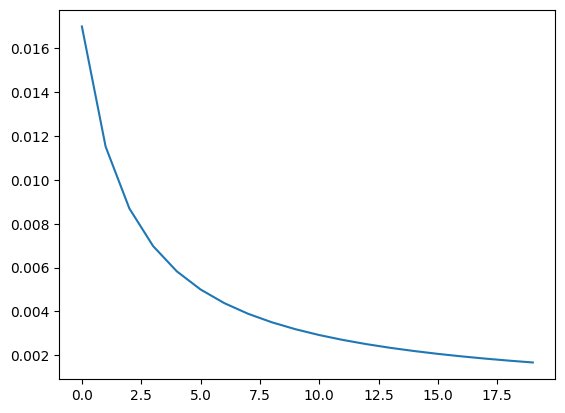

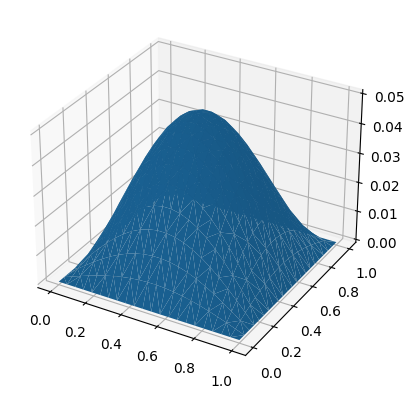

In [54]:
erroPlot(20)

In [55]:
def f(x, y) :
    return np.sin(np.pi * x) * np.sin(np.pi * y)

def u(x, y) :
    return np.sin(np.pi * x) * np.sin(np.pi * y) / (2 * np.pi**2)

L'erreur vaut
 0.0007163344168022495


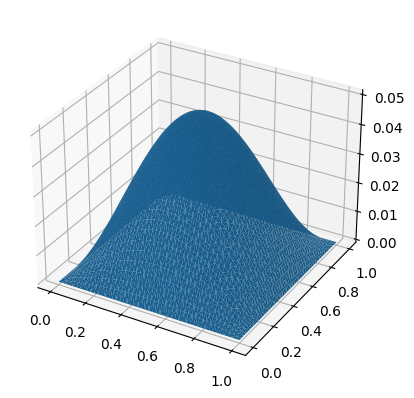

In [56]:
n = 50
coordinates, elements3, dirichlet, neumann = maillage(n)
dirichlet = np.sort(dirichlet, 0)

A = raideur(n, coordinates, elements3)
ud = np.zeros(n*n)
b = secondMembre(n, coordinates, A, ud, f, elements3)
Ared = reduireA(A, dirichlet)
bred = reduireB(b, dirichlet)
#print("La matrice A réduite est\n", Ared)

x = np.linalg.solve(Ared, np.transpose(bred))
#print("La solution intérieure est\n", x)
sol = rassembler(dirichlet, ud, x, n)
#print("La solution rassemblée est\n", sol)

theorique = [u(p[0], p[1]) for p in coordinates]
#print("La solution théorique est\n", theorique)

print("L'erreur vaut\n", np.linalg.norm(theorique - sol))
#print("La figure de la solution théorique est")
#show(coordinates,theorique)
#print("La figure de la solution est")


show(coordinates,sol)

# Si on augmente n, l'erreur décroit -> plot de l'erreur en fonction de n

**Partie II : maillage mixte et ajoût des conditions de Neumann**

In [57]:
############################# Maillage mixte ################
e3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)
e4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)
# dds=np.array([1, 5, 2,15,4,6,7,8,9,10,11,0]).astype(int)
# nns=np.array([]).astype(int)
dds=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int)
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)
ccs=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.],
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
                     [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]])

In [58]:
def raideurElemQ(Q, coordinates) :

    Q = [coordinates[Q[i]] for i in range(4)]
    Jacobien = np.array([[Q[1][0]-Q[0][0], Q[3][0]-Q[0][0]],
                         [Q[1][1]-Q[0][1], Q[3][1]-Q[0][1]]])
    detJ = Jacobien[0][0] * Jacobien[1][1] - Jacobien[0][1] * Jacobien[1][0]
    prodJaco = np.transpose(Jacobien) * Jacobien
    detProdJaco = prodJaco[0][0] * prodJaco[1][1] - prodJaco[0][1] * prodJaco[1][0]
    InvProdJaco = np.array([[prodJaco[1][1] , - prodJaco[0][1]],
                      [-prodJaco[1][0] , prodJaco[0][0]]])/detProdJaco

    a = InvProdJaco[0][0]
    # L'élément 1,2 et l'élément 2,1 de la matrice InvProdJaco sont égales car
    # la matrice est symétrique.
    b = InvProdJaco[0][1]
    c = InvProdJaco[1][1]

    M = np.array([[2*a+3*b+2*c, c-2*a,        -a-3*b-c,       a-2*c],
                  [c-2*a,        2*a-3*b+2*c, a-2*c,           -a+3*b+c],
                  [-a-3*b-c,    a-2*c,        2*a+3*b+2*c,    -2*a+c],
                  [a-2*c,        -a+3*b+c,    -2*a+c,          2*a-3*b+2*c]])

    M = M * detJ/6

    return M






In [59]:
def raideurQ(n, coordinates, elements4) :
    A = np.zeros((n*n,n*n))
    for e in elements4 :
        M = raideurElemQ(e, coordinates)
        for i, elt_i in enumerate(e) :  #enumerate(e): pour trouver l'indice, puis la valeur
            for j, elt_j in enumerate(e) :
                A[elt_i, elt_j] += M[i][j]

    return A

In [61]:
def f(x, y) :
    return np.sin(np.pi * x) * np.sin(np.pi * y)

def u(x, y) :
    return np.sin(np.pi * x) * np.sin(np.pi * y) / (2 * np.pi**2)

def g(x, y) :
    return 1

n vaut  4
Le terme de Neumann bn dans b vaut  [0.         0.         0.         0.         0.53166667 1.06333333
 0.53166667 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
L'erreur vaut
 2.6736780956325132
La figure de la solution théorique est


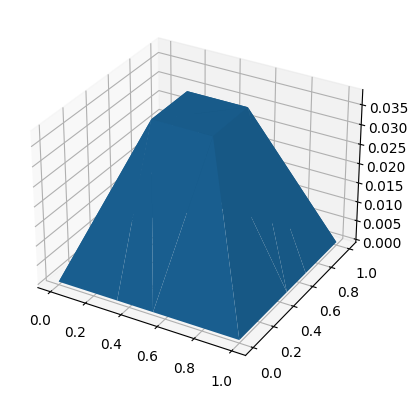

La figure de la solution est


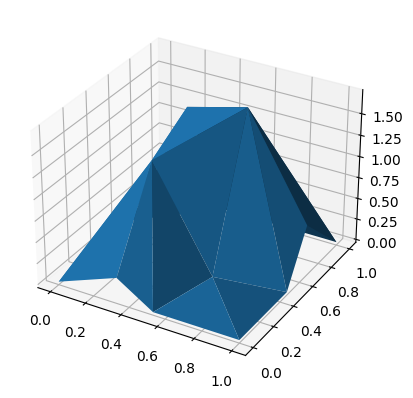

In [62]:
n = int(np.sqrt(len(ccs)))
print("n vaut ", n)
# coordinates, elements3, dirichlet, neumann = maillage(n)
# dirichlet = np.sort(dirichlet, 0)


A = raideurQ(n, ccs, e4)
A = A + raideur(n, ccs, e3)

ud = np.zeros(n*n)

b = secondMembre(n, ccs, A, ud, f, e3)
b += secondMembre(n, ccs, A, ud, f, e4)
# print(b.size)
bn = bNeuman(n, nns, ccs, g)
print("Le terme de Neumann bn dans b vaut ", bn)
b += bn


Ared = reduireA(A, [dds])
bred = reduireB(b, [dds])
#print("La matrice A réduite est\n", Ared)

x = np.linalg.solve(Ared, np.transpose(bred))
#print("La solution intérieure est\n", x)
sol = rassembler(dds, ud, x, n)
#print("La solution rassemblée est\n", sol)

theorique = [u(p[0], p[1]) for p in ccs]
#print("La solution théorique est\n", theorique)

print("L'erreur vaut\n", np.linalg.norm(theorique - sol))
print("La figure de la solution théorique est")
show(ccs,theorique)

print("La figure de la solution est")


show(ccs,sol)

**Compléments  :  un nouveau terme dans l'EDP**

A présent, nous nous intéressons au problème suivant avec les notations précédentes :
$$
\left\{
    \begin{array}{ll}
        \begin{aligned}
            -\Delta u(x,y) + c_0 u(x,y) = f(x,y) & \,  sur ~ \Omega, \\
            u(x,y) = 0 & \, sur  ~ \partial \Omega,
        \end{aligned}
    \end{array}
\right.
$$

avec $c_0 > 0$ une constante.

Nous allons résoudre ce problème en le discrétisant par la méthode des éléments finis de Lagrange avec des éléments finis de type $P_1$, comme ce qui a été réalisé en Partie I.

$\underline{\textbf{Question :}}$

$\textbf{Montrer que la formulation variationnelle du problème s’écrit : Trouver }$ $u \in H^1_0(\Omega)$ telle que
$$
\int_\Omega {\nabla u . \nabla w} \, \mathrm{d}x + c_0 \int_\Omega {u w} \, \mathrm{d}x = \int_\Omega {f w} \, \mathrm{d}x
$$ 
avec $w \in H^1_0(\Omega)$.

$\textbf{Montrer également que le problème admet une unique solution.}$

$\underline{\textbf{Réponse :}}$

Tout d'abord, on intégre la première equation du système sur $\Omega$, on a : $$ \int_\Omega {-\Delta u + c_0 u} \, \mathrm{d}x =  \int_\Omega {f} \, \mathrm{d}x$$
En multipliant de plus par un $w \in L^2(\Omega)$ on obtient alors : $$\int_\Omega {-\Delta u w + c_0 u w} \, \mathrm{d}x =  \int_\Omega {f w} \, \mathrm{d}x$$

Soit $v \in H^1(\Omega)$ et $u \in H^2(\Omega)$, d'après la formule de Green, on a: 
$$- \int_\Omega {\Delta u  v} \, \mathrm{d}x = \int_\Omega {\nabla u . \nabla v} \, \mathrm{d}x - \int_{\partial\Omega} {\gamma_1(u) \gamma_0 (v)} \, \mathrm{d}x 
$$.

Alors pour notre $u \in H^2(\Omega)$, et pour un $w \in H^1(\Omega)$ (car $H^1(\Omega) \subseteq L^2(\Omega) $), on aura
$$ 
\displaystyle \int_\Omega {\nabla u . \nabla w} \, \mathrm{d}x + c_0 \int_\Omega {u w} \, \mathrm{d}x = \int_\Omega {fw} \, \mathrm{d}x + \int_{\partial\Omega} {\gamma_1(u) \gamma_0 (w)} \, \mathrm{d}x \\
$$
Ainsi $u \in H^1(\Omega)$.

On a d'après la deuxième équation du système, $\forall(x,y) \in \partial\Omega$  $u(x,y) = 0$ donc $u \in H^1_0(\Omega)$.

Pour $w$ appartenant à $H^1_0(\Omega)$, $\gamma_0(w) = 0$ sur $\partial\Omega$, alors  $\int_{\partial\Omega} {\gamma_1(u) \gamma_0 (w)} \, \mathrm{d}x = 0$. 

Alors, on a bien: 
$$ 
\int_\Omega {\nabla u . \nabla w} \, \mathrm{d}x + c_0 \int_\Omega {u w} \, \mathrm{d}x = \int_\Omega {fw} \, \mathrm{d}x
$$

Alors on a 
$$ \int_\Omega {\nabla v . \nabla w} \, \mathrm{d}x + c_0 \int_\Omega {u w} \, \mathrm{d}x = \int_\Omega {fw} \, \mathrm{d}x
$$ avec $w \in H^1_0(\Omega)$ et $u \in H^1_0(\Omega)$.

D'où le résultat.